In [24]:
import pandas as pd
import mujoco_py
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

from keras.layers import Input, Conv2D, Conv1D, MaxPooling2D, Dense, \
                        Flatten, Dropout, Reshape
from keras.models import Model, Sequential
from keras import optimizers
from keras.regularizers import l1_l2
from keras.initializers import Zeros as initZeros

from keras.models import load_model
from keras.models import model_from_json
import datetime
import sys
from sklearn.metrics import mean_squared_error as mse
from keras.losses import mean_squared_error

In [27]:
def open_and_load(string):
    """Open model and load weights"""
    with open(string+'.json', 'r') as f:
        model = model_from_json(f.read())
    model.load_weights(string+'.h5')
    return model

def load_128_images_starting(a):
    """Loads 128 images starting with a. Loading all images crashes."""
    images = []
    loc = "/home/erik/mujocopy_testikas/frames/"
    for i in range(a,a+128):
        s = ("%.4d" % i) #0200
        images += [cv2.imread(loc+"img_"+s+".png")]
    return images

def save_model(model, model_str):
    """Saves model with weights."""
    model_json = model.to_json()
    with open('models/'+model_str+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights('models/'+model_str+".h5")
    print("Saved model to disk, name: ", model_str)

df = pd.read_csv('df.csv')

In [28]:
model = open_and_load("models/model_2019-05-28_01:34:19.702201")
#print("HISTORY!")
#print(model.get_weights())
model.compile(optimizer='adam',
             loss='mean_squared_error')

In [29]:
def test_single_instance(i):
    img = cv2.imread(("/home/erik/mujocopy_testikas/frames/img_%.4d.png" % i))
    X = np.array([img])
    p = model.predict(X)[0]
    y = df.iloc[i][:2]
    print("RMSE on single instance: ", np.sqrt(np.mean((p-y)**2)))

test_single_instance(1)

RMSE on single instance:  0.15450607543823985


In [5]:
i = 1
img = cv2.imread(("/home/erik/mujocopy_testikas/frames/img_%.4d.png" % i))
X = np.array([img])
p = model.predict(X)[0]
y = df.iloc[i][:2]

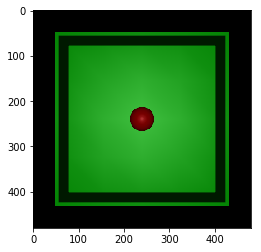

In [6]:
plt.imshow(img)

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 480, 480, 3)       0         
_________________________________________________________________
conv (Conv2D)                (None, 480, 480, 1)       4         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 240, 240, 1)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 240, 240, 1)       10        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 120, 120, 1)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 14400)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 28802     
Total para

In [17]:
X = np.array(load_128_images_starting(9200))
p = model.predict(X)[0]
y = df.iloc[i][:2]

In [19]:
mse(y,p)

0.049708844328005035

# Combining coordinates retriever with prediction module

In [25]:
model_2d = open_and_load('models/model_2d')
model_2d.compile(loss=mean_squared_error,
              optimizer='adam')

In [30]:
inputs = Input(shape=(480,480,3))

ret = model(inputs)

model_combined = Model(inputs=inputs, outputs=ret)
model_combined.compile(optimizer='adam',
             loss='mean_squared_error')

In [31]:
model_combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 480, 480, 3)       0         
_________________________________________________________________
model_2 (Model)              (None, 2)                 28816     
Total params: 28,816
Trainable params: 28,816
Non-trainable params: 0
_________________________________________________________________


In [35]:
# from copy import deepcopy
# og_weights = deepcopy(model.get_weights())

In [48]:
img = cv2.imread("/home/erik/mujocopy_testikas/frames/img_0501.png")
A = np.array([img])
B = np.array([df.iloc[501,:2]])

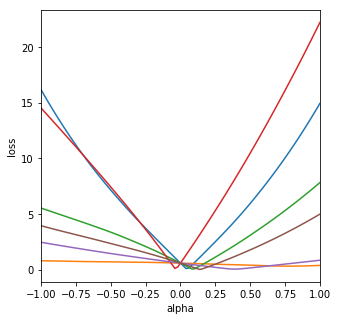

In [51]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.set(xlim=(-1, 1))
ax.set_xlabel('alpha')
ax.set_ylabel('loss')
for _ in range(6):
    model.set_weights(og_weights)
    delta = deepcopy(model.get_weights())
    theta = []
    for weights in delta:
        theta += [weights * np.random.normal(loc=1.0, scale=0.5, size=weights.shape)]

    def get_weight_combo(alpha):
        l = []

        for i in range(len(delta)):
            l += [ delta[i]*(1-alpha) + theta[i]*alpha]
        return l


    rmse_list = []
    alphas = np.linspace(-1, 1, num=101)
    for alpha in alphas:
        weights = get_weight_combo(alpha)
        model.set_weights(weights)
        P = model.predict(A)
        rmse_list += [mse(B, P)**0.5]


    # line = ax.plot([0,1],[0,0])

    plt.plot(alphas, rmse_list)
plt.show()

In [52]:
fig.savefig('coord_ret_loss.png')